In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import regex as re

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, normalize
from sklearn.model_selection import train_test_split, GridSearchCV

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, Activation, Dropout
from keras.metrics import RootMeanSquaredError
%matplotlib inline

### Loading Preprocessed Dataset

In [2]:
df = pd.read_csv('tmp/mse_raw.csv', parse_dates=['date', 'start_date'], index_col='Unnamed: 0')

In [3]:
df.head(5)

,stock_id,date,open,high,low,average,close,volume,quantity,change %,volume total,start_date
0,ALK,1997-01-09,1070.0,1070.0,1070.0,1070.0,1070.0,279270.0,261.0,0.0,279270.0,1997-01-09
22,ALK,1997-01-10,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09
44,ALK,1997-01-11,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09
66,ALK,1997-01-12,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09
88,ALK,1997-01-13,1070.0,1070.0,1070.0,1070.0,1070.0,0.0,0.0,0.0,0.0,1997-01-09


### setting RNN ALK dataset for training, validation and test

In [4]:
alk_df = df[df.stock_id == 'ALK']

In [5]:
alk_df.columns

Index(['stock_id', 'date', 'open', 'high', 'low', 'average', 'close', 'volume',
       'quantity', 'change %', 'volume total', 'start_date'],
      dtype='object')

### split dataset

In [6]:
#Create a new dataframe with only closing price column
close_price = alk_df['close']

#Convert the dataframe into numpy array
close_price = close_price.values

In [7]:
close_price.shape

(8630,)

In [8]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [9]:
scaled_df = scaler.fit_transform(close_price.reshape(len(close_price), 1))

In [10]:
scaled_df

array([[0.04175824],
       [0.04175824],
       [0.04175824],
       ...,
       [0.86373626],
       [0.86373626],
       [0.85714286]])

### univariate sequence

In [11]:
# split a univariate sequence into samples with one day prediciton
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [12]:
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(scaled_df, n_steps)
# summarize the data
for i in range(3):
    print(X[i], y[i])

[[0.04175824]
 [0.04175824]
 [0.04175824]] [0.04175824]
[[0.04175824]
 [0.04175824]
 [0.04175824]] [0.04175824]
[[0.04175824]
 [0.04175824]
 [0.04175824]] [0.04029304]


### Vanilla LSTM, one day prediciton

In [13]:
X_train, X_valid, X_test = X[:int(len(X)-60),], X[int(len(X)-60):int(len(X)-1),], X[int(len(X)-1):,]
y_train, y_valid, y_test = y[:int(len(X)-60),], y[int(len(X)-60):int(len(X)-1),], y[int(len(X)-1):,]

In [14]:
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((8567, 3, 1), (59, 3, 1), (1, 3, 1), (8567, 1), (59, 1), (1, 1))

In [15]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [20]:
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
rmse = RootMeanSquaredError()

In [27]:
def reg(optimizer):
    #initialisizng the model 
    regression= Sequential()

    #First Input layer and LSTM layer with 0.2% dropout
    regression.add(LSTM(units=50,return_sequences=True,kernel_initializer='glorot_uniform',input_shape=(X_train.shape[1],1)))
    regression.add(Dropout(0.2))

    # Second LSTM layer with 0.2% dropout
    regression.add(LSTM(units=50,kernel_initializer= 'glorot_uniform',return_sequences=True))
    regression.add(Dropout(0.2))

    #Third LSTM layer with 0.2% dropout
    regression.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
    regression.add(Dropout(0.2))

    #Fourth LSTM layer with 0.2% dropout, we wont use return sequence true in last layers as we dont want to previous output
    regression.add(LSTM(units=50,kernel_initializer='glorot_uniform'))
    regression.add(Dropout(0.2))
    #Output layer , we wont pass any activation as its continous value model
    regression.add(Dense(units=1))

    #Compiling the network
    regression.compile(optimizer=optimizer,loss='mean_squared_error')
    
    return regression

model= KerasRegressor(build_fn=reg)

In [28]:
from sklearn.model_selection import RandomizedSearchCV
parameters = {'batch_size': [50, 32],
              'epochs': [50, 25],
              'optimizer': ['adam']}

In [29]:
my_callback1 = ModelCheckpoint('vanila_best.pt', verbose=1, save_best_only=True, mode='min', monitor='val_loss')
my_callback2 = EarlyStopping(patience=10)

my_callbacks = [my_callback1, my_callback2]

In [30]:
grid_search = RandomizedSearchCV(estimator = model,param_distributions=parameters,n_iter=5)
# fitting the model and Calculating the best parameters.
grid_search = grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
138/138 [==============================] - 2s 12ms/step - loss: 0.0231
Epoch 2/50
138/138 [==============================] - 2s 13ms/step - loss: 0.0018
Epoch 3/50
138/138 [==============================] - 2s 12ms/step - loss: 0.0015
Epoch 4/50
138/138 [==============================] - 2s 14ms/step - loss: 0.0013
Epoch 5/50
138/138 [==============================] - 2s 11m

138/138 [==============================] - 2s 13ms/step - loss: 9.4401e-04
Epoch 14/50
138/138 [==============================] - 2s 12ms/step - loss: 9.1894e-04
Epoch 15/50
138/138 [==============================] - 2s 12ms/step - loss: 9.1552e-04
Epoch 16/50
138/138 [==============================] - 2s 12ms/step - loss: 9.1963e-04
Epoch 17/50
138/138 [==============================] - 2s 12ms/step - loss: 8.4314e-04
Epoch 18/50
138/138 [==============================] - 2s 12ms/step - loss: 8.5391e-04
Epoch 19/50
138/138 [==============================] - 2s 12ms/step - loss: 8.3442e-04
Epoch 20/50
138/138 [==============================] - 2s 12ms/step - loss: 7.9969e-04
Epoch 21/50
138/138 [==============================] - 2s 12ms/step - loss: 7.4550e-04
Epoch 22/50
138/138 [==============================] - 2s 13ms/step - loss: 7.2727e-04
Epoch 23/50
138/138 [==============================] - 2s 14ms/step - loss: 7.0922e-04: 0s - loss: 7.
Epoch 24/50
138/138 [===================

138/138 [==============================] - 2s 12ms/step - loss: 5.0981e-04
Epoch 36/50
138/138 [==============================] - 2s 13ms/step - loss: 4.9109e-04
Epoch 37/50
138/138 [==============================] - 2s 13ms/step - loss: 5.5252e-04
Epoch 38/50
138/138 [==============================] - 2s 12ms/step - loss: 5.1147e-04
Epoch 39/50
138/138 [==============================] - 2s 12ms/step - loss: 4.8326e-04
Epoch 40/50
138/138 [==============================] - 2s 12ms/step - loss: 4.7826e-04: 0s - loss:
Epoch 41/50
138/138 [==============================] - 2s 14ms/step - loss: 4.6324e-04
Epoch 42/50
138/138 [==============================] - 2s 13ms/step - loss: 5.0005e-04
Epoch 43/50
138/138 [==============================] - 2s 13ms/step - loss: 4.4993e-04
Epoch 44/50
138/138 [==============================] - 2s 12ms/step - loss: 4.7635e-04
Epoch 45/50
138/138 [==============================] - 2s 13ms/step - loss: 4.8072e-04
Epoch 46/50
138/138 [======================

35/35 [==============================] - 0s 4ms/step - loss: 2.1697e-04
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
138/138 [==============================] - 2s 13ms/step - loss: 0.0140
Epoch 2/50
138/138 [==============================] - 2s 13ms/step - loss: 0.0010
Epoch 3/50
138/138 [==============================] - 2s 12ms/step - loss: 9.2401e-04
Epoch 4/50
138/138 [==============================] - 2s 12ms/step

Epoch 12/25
138/138 [==============================] - 2s 14ms/step - loss: 9.7677e-04
Epoch 13/25
138/138 [==============================] - 2s 13ms/step - loss: 8.9654e-04
Epoch 14/25
138/138 [==============================] - 2s 14ms/step - loss: 9.3261e-04
Epoch 15/25
138/138 [==============================] - 2s 14ms/step - loss: 8.4762e-04
Epoch 16/25
138/138 [==============================] - 2s 13ms/step - loss: 8.4701e-04
Epoch 17/25
138/138 [==============================] - 2s 13ms/step - loss: 8.0695e-04: 0s 
Epoch 18/25
138/138 [==============================] - 2s 13ms/step - loss: 8.0245e-04
Epoch 19/25
138/138 [==============================] - 2s 13ms/step - loss: 7.5248e-04
Epoch 20/25
138/138 [==============================] - 2s 13ms/step - loss: 7.4468e-04
Epoch 21/25
138/138 [==============================] - 2s 13ms/step - loss: 7.4661e-04
Epoch 22/25
138/138 [==============================] - 2s 13ms/step - loss: 6.9167e-04
Epoch 23/25
138/138 [=================

138/138 [==============================] - 2s 15ms/step - loss: 6.5288e-04
Epoch 14/25
138/138 [==============================] - 2s 15ms/step - loss: 6.7655e-04: 0s - loss: 7.09 - ETA: 0s - loss: 
Epoch 15/25
138/138 [==============================] - 2s 13ms/step - loss: 6.1772e-04
Epoch 16/25
138/138 [==============================] - 2s 13ms/step - loss: 6.5611e-04
Epoch 17/25
138/138 [==============================] - 2s 13ms/step - loss: 6.0260e-04
Epoch 18/25
138/138 [==============================] - 2s 13ms/step - loss: 5.7986e-04
Epoch 19/25
138/138 [==============================] - 2s 13ms/step - loss: 5.8564e-04
Epoch 20/25
138/138 [==============================] - 2s 14ms/step - loss: 5.9179e-04
Epoch 21/25
138/138 [==============================] - 2s 14ms/step - loss: 5.5826e-04
Epoch 22/25
138/138 [==============================] - 2s 14ms/step - loss: 5.5532e-04: 0s - loss: 5.5
Epoch 23/25
138/138 [==============================] - 2s 14ms/step - loss: 5.3348e-04
Epo

138/138 [==============================] - 2s 14ms/step - loss: 5.5380e-04
Epoch 14/25
138/138 [==============================] - 2s 14ms/step - loss: 5.6183e-04
Epoch 15/25
138/138 [==============================] - 2s 14ms/step - loss: 5.1542e-04
Epoch 16/25
138/138 [==============================] - 2s 14ms/step - loss: 5.1122e-04
Epoch 17/25
138/138 [==============================] - 2s 14ms/step - loss: 5.0938e-04
Epoch 18/25
138/138 [==============================] - 2s 15ms/step - loss: 5.0407e-04
Epoch 19/25
138/138 [==============================] - 2s 15ms/step - loss: 5.1056e-04
Epoch 20/25
138/138 [==============================] - 2s 15ms/step - loss: 5.1095e-04
Epoch 21/25
138/138 [==============================] - 2s 14ms/step - loss: 5.5395e-04
Epoch 22/25
138/138 [==============================] - 2s 14ms/step - loss: 4.8657e-04
Epoch 23/25
138/138 [==============================] - 2s 14ms/step - loss: 4.8467e-04
Epoch 24/25
138/138 [==============================] - 

54/54 [==============================] - 0s 4ms/step - loss: 6.5294e-04
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
215/215 [==============================] - 3s 13ms/step - loss: 0.0144
Epoch 2/50
215/215 [==============================] - 3s 12ms/step - loss: 0.0015
Epoch 3/50
215/215 [==============================] - 3s 13ms/step - loss: 0.0013
Epoch 4/50
215/215 [==============================] - 3s 12ms/step - l

215/215 [==============================] - 2s 11ms/step - loss: 6.9993e-04
Epoch 12/50
215/215 [==============================] - 2s 11ms/step - loss: 6.7729e-04
Epoch 13/50
215/215 [==============================] - 3s 12ms/step - loss: 6.1764e-04
Epoch 14/50
215/215 [==============================] - 2s 11ms/step - loss: 6.6380e-04
Epoch 15/50
215/215 [==============================] - 3s 12ms/step - loss: 6.0622e-04
Epoch 16/50
215/215 [==============================] - 3s 12ms/step - loss: 5.6956e-04
Epoch 17/50
215/215 [==============================] - 3s 12ms/step - loss: 5.7696e-04
Epoch 18/50
215/215 [==============================] - 2s 11ms/step - loss: 5.5036e-04
Epoch 19/50
215/215 [==============================] - 2s 12ms/step - loss: 5.1354e-04
Epoch 20/50
215/215 [==============================] - 2s 12ms/step - loss: 5.0692e-04
Epoch 21/50
215/215 [==============================] - 3s 13ms/step - loss: 5.5730e-04
Epoch 22/50
215/215 [==============================] - 

215/215 [==============================] - 3s 13ms/step - loss: 6.8524e-04
Epoch 34/50
215/215 [==============================] - 3s 13ms/step - loss: 6.8581e-04
Epoch 35/50
215/215 [==============================] - 3s 12ms/step - loss: 6.8321e-04
Epoch 36/50
215/215 [==============================] - 3s 12ms/step - loss: 6.7850e-04
Epoch 37/50
215/215 [==============================] - 3s 12ms/step - loss: 6.3965e-04
Epoch 38/50
215/215 [==============================] - 3s 12ms/step - loss: 6.8251e-04
Epoch 39/50
215/215 [==============================] - 3s 13ms/step - loss: 6.8101e-04
Epoch 40/50
215/215 [==============================] - 3s 13ms/step - loss: 6.9712e-04
Epoch 41/50
215/215 [==============================] - 3s 13ms/step - loss: 7.0890e-04
Epoch 42/50
215/215 [==============================] - 3s 13ms/step - loss: 7.4253e-04: 0s - loss: 7.
Epoch 43/50
215/215 [==============================] - 3s 12ms/step - loss: 6.6609e-04
Epoch 44/50
215/215 [===================

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
54/54 [==============================] - 0s 6ms/step - loss: 1.9627e-04
Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

54/54 [==============================] - 0s 4ms/step - loss: 7.5262e-05
Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
215/215 [==============================] - 3s 14ms/step - loss: 0.0100
Epoch 2/25
215/215 [==============================] - 3s 14ms/step - loss: 0.0011
Epoch 3/25
215/215 [==============================] - 3s 15ms/step - loss: 9.8738e-04
Epoch 4/25
215/215 [==============================] - 3s 14ms/step

54/54 [==============================] - 0s 5ms/step - loss: 7.4008e-04
Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
215/215 [==============================] - 3s 16ms/step - loss: 0.0096
Epoch 2/25
215/215 [==============================] - 4s 20ms/step - loss: 0.0011
Epoch 3/25
215/215 [==============================] - 5s 23ms/step - loss: 8.2160e-04: 2s - loss - ETA: 2s - loss: 8.622
Epoch 4/25
215/215 [===========

268/268 [==============================] - 4s 16ms/step - loss: 5.6427e-04: 1s - loss: 5.6501e - ETA: 1s 
Epoch 35/50
268/268 [==============================] - 4s 16ms/step - loss: 5.9538e-04
Epoch 36/50
268/268 [==============================] - 4s 16ms/step - loss: 5.4413e-04
Epoch 37/50
268/268 [==============================] - 5s 18ms/step - loss: 5.4930e-04
Epoch 38/50
268/268 [==============================] - 5s 19ms/step - loss: 5.4126e-04
Epoch 39/50
268/268 [==============================] - 5s 17ms/step - loss: 5.5755e-04: 1s -
Epoch 40/50
268/268 [==============================] - 4s 16ms/step - loss: 5.3608e-04
Epoch 41/50
268/268 [==============================] - 4s 14ms/step - loss: 5.7611e-04
Epoch 42/50
268/268 [==============================] - 4s 15ms/step - loss: 5.6859e-04
Epoch 43/50
268/268 [==============================] - 4s 16ms/step - loss: 5.4111e-04
Epoch 44/50
268/268 [==============================] - 7s 26ms/step - loss: 5.2412e-04
Epoch 45/50
268/26

In [38]:
model=grid_search.best_estimator_.fit(X_train,y_train)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
268/268 [==============================] - 5s 18ms/step - loss: 0.0113
Epoch 2/50
268/268 [==============================] - 5s 19ms/step - loss: 0.0013
Epoch 3/50
268/268 [==============================] - 5s 18ms/step - loss: 0.0011
Epoch 4/50
268/268 [==============================] - 5s 20ms/step - loss: 9.7102e-04
Epoch 5/50
268/268 [==============================] - 5s

In [39]:
yhat = grid_search.predict(X_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [40]:
y_actual = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred = scaler.inverse_transform(yhat.reshape(-1,1))

In [41]:
np.sqrt(mean_squared_error(y_actual, y_pred))

405.4619140625

### Stacked LSTM, one day prediciton

In [42]:
def reg(optimizer):
    regression = Sequential()
    regression.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    regression.add(LSTM(50, activation='relu'))
    regression.add(Dense(1))
    regression.compile(optimizer='adam', loss='mse')
    return regression

model= KerasRegressor(build_fn=reg)

In [43]:
# fit model
grid_search = RandomizedSearchCV(estimator = model,param_distributions=parameters,n_iter=5)
# fitting the model and Calculating the best parameters.
grid_search = grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
138/138 [==============================] - 1s 9ms/step - loss: 0.0249
Epoch 2/50
138/138 [==============================] - 2s 13ms/step - loss: 1.3582e-04: 0s - loss: 1.396 - ETA: 0s - loss: 1.3478e
Epoch 3/50
138/138 [==============================] - 1s 11ms/step - loss: 1.1547e-04
Epoch 4/50
138/138 [==============================] - 2s 12ms/step - loss: 1.1026e-04
Epoch

138/138 [==============================] - 2s 11ms/step - loss: 1.0505e-04
Epoch 12/50
138/138 [==============================] - 2s 11ms/step - loss: 1.0413e-04
Epoch 13/50
138/138 [==============================] - 1s 11ms/step - loss: 1.0392e-04
Epoch 14/50
138/138 [==============================] - 1s 11ms/step - loss: 1.0450e-04
Epoch 15/50
138/138 [==============================] - 1s 9ms/step - loss: 1.1127e-04
Epoch 16/50
138/138 [==============================] - 1s 10ms/step - loss: 1.0082e-04
Epoch 17/50
138/138 [==============================] - 1s 10ms/step - loss: 9.7899e-05
Epoch 18/50
138/138 [==============================] - 1s 10ms/step - loss: 1.0592e-04
Epoch 19/50
138/138 [==============================] - 1s 10ms/step - loss: 1.0368e-04
Epoch 20/50
138/138 [==============================] - 1s 10ms/step - loss: 1.0410e-04
Epoch 21/50
138/138 [==============================] - 1s 11ms/step - loss: 1.0255e-04
Epoch 22/50
138/138 [==============================] - 2

138/138 [==============================] - 1s 10ms/step - loss: 5.3288e-05
Epoch 34/50
138/138 [==============================] - 1s 11ms/step - loss: 6.3634e-05
Epoch 35/50
138/138 [==============================] - 1s 10ms/step - loss: 5.7267e-05
Epoch 36/50
138/138 [==============================] - 1s 9ms/step - loss: 5.5325e-05A: 0s - loss: 5.5770e-
Epoch 37/50
138/138 [==============================] - 1s 9ms/step - loss: 5.5080e-05
Epoch 38/50
138/138 [==============================] - 1s 10ms/step - loss: 5.2879e-05
Epoch 39/50
138/138 [==============================] - 1s 10ms/step - loss: 5.7744e-05
Epoch 40/50
138/138 [==============================] - 1s 9ms/step - loss: 5.1832e-05
Epoch 41/50
138/138 [==============================] - 1s 9ms/step - loss: 5.3121e-05
Epoch 42/50
138/138 [==============================] - 1s 9ms/step - loss: 5.4791e-05
Epoch 43/50
138/138 [==============================] - 1s 9ms/step - loss: 5.5469e-05
Epoch 44/50
138/138 [==================

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
35/35 [==============================] - 0s 4ms/step - loss: 1.6950e-05
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

138/138 [==============================] - 1s 10ms/step - loss: 1.1192e-04
Epoch 8/25
138/138 [==============================] - 1s 10ms/step - loss: 1.0828e-04
Epoch 9/25
138/138 [==============================] - 1s 9ms/step - loss: 1.3486e-04
Epoch 10/25
138/138 [==============================] - 1s 9ms/step - loss: 1.0672e-04
Epoch 11/25
138/138 [==============================] - 1s 10ms/step - loss: 1.0859e-04
Epoch 12/25
138/138 [==============================] - 1s 10ms/step - loss: 1.0631e-04
Epoch 13/25
138/138 [==============================] - 1s 10ms/step - loss: 1.0691e-04
Epoch 14/25
138/138 [==============================] - 1s 10ms/step - loss: 1.0616e-04
Epoch 15/25
138/138 [==============================] - 1s 11ms/step - loss: 1.0703e-04
Epoch 16/25
138/138 [==============================] - 1s 10ms/step - loss: 1.1430e-04
Epoch 17/25
138/138 [==============================] - 1s 10ms/step - loss: 1.0341e-04
Epoch 18/25
138/138 [==============================] - 1s 1

138/138 [==============================] - 1s 10ms/step - loss: 5.7616e-05
Epoch 8/25
138/138 [==============================] - 1s 10ms/step - loss: 5.5201e-05
Epoch 9/25
138/138 [==============================] - 1s 10ms/step - loss: 5.6431e-05
Epoch 10/25
138/138 [==============================] - 1s 10ms/step - loss: 5.6541e-05
Epoch 11/25
138/138 [==============================] - 1s 9ms/step - loss: 5.8413e-05
Epoch 12/25
138/138 [==============================] - 1s 9ms/step - loss: 5.6985e-05
Epoch 13/25
138/138 [==============================] - 1s 10ms/step - loss: 5.5230e-05
Epoch 14/25
138/138 [==============================] - 1s 10ms/step - loss: 5.6154e-05
Epoch 15/25
138/138 [==============================] - 1s 10ms/step - loss: 5.7529e-05
Epoch 16/25
138/138 [==============================] - 1s 10ms/step - loss: 5.6096e-05: 0s 
Epoch 17/25
138/138 [==============================] - 1s 10ms/step - loss: 5.6607e-05
Epoch 18/25
138/138 [==============================] -

138/138 [==============================] - 1s 11ms/step - loss: 8.5943e-05
Epoch 8/25
138/138 [==============================] - 1s 10ms/step - loss: 9.2430e-05: 
Epoch 9/25
138/138 [==============================] - 1s 10ms/step - loss: 9.6278e-05
Epoch 10/25
138/138 [==============================] - 1s 10ms/step - loss: 8.6912e-05
Epoch 11/25
138/138 [==============================] - 1s 9ms/step - loss: 9.6551e-05
Epoch 12/25
138/138 [==============================] - 1s 9ms/step - loss: 9.1280e-05
Epoch 13/25
138/138 [==============================] - 1s 9ms/step - loss: 9.4971e-05
Epoch 14/25
138/138 [==============================] - 1s 9ms/step - loss: 9.1461e-05
Epoch 15/25
138/138 [==============================] - 1s 9ms/step - loss: 9.0006e-05
Epoch 16/25
138/138 [==============================] - 1s 9ms/step - loss: 8.5018e-05
Epoch 17/25
138/138 [==============================] - 1s 9ms/step - loss: 8.2793e-05
Epoch 18/25
138/138 [==============================] - 1s 9ms/

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
54/54 [==============================] - 0s 3ms/step - loss: 4.5342e-05
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

215/215 [==============================] - 2s 8ms/step - loss: 5.9806e-05
Epoch 8/50
215/215 [==============================] - 2s 8ms/step - loss: 6.0198e-05
Epoch 9/50
215/215 [==============================] - 2s 8ms/step - loss: 5.7287e-05
Epoch 10/50
215/215 [==============================] - 2s 8ms/step - loss: 5.9353e-05
Epoch 11/50
215/215 [==============================] - 2s 8ms/step - loss: 5.9965e-05
Epoch 12/50
215/215 [==============================] - 2s 8ms/step - loss: 6.2628e-05
Epoch 13/50
215/215 [==============================] - 2s 8ms/step - loss: 5.6677e-05
Epoch 14/50
215/215 [==============================] - 2s 8ms/step - loss: 5.7064e-05
Epoch 15/50
215/215 [==============================] - 2s 8ms/step - loss: 6.0571e-05
Epoch 16/50
215/215 [==============================] - 2s 9ms/step - loss: 5.8858e-05
Epoch 17/50
215/215 [==============================] - 2s 9ms/step - loss: 6.0405e-05
Epoch 18/50
215/215 [==============================] - 2s 9ms/step -

215/215 [==============================] - 2s 8ms/step - loss: 1.0165e-04
Epoch 31/50
215/215 [==============================] - 2s 8ms/step - loss: 1.0558e-04
Epoch 32/50
215/215 [==============================] - 2s 8ms/step - loss: 9.6740e-05
Epoch 33/50
215/215 [==============================] - 2s 8ms/step - loss: 1.0146e-04
Epoch 34/50
215/215 [==============================] - 2s 8ms/step - loss: 9.4549e-05
Epoch 35/50
215/215 [==============================] - 2s 8ms/step - loss: 9.1728e-05
Epoch 36/50
215/215 [==============================] - 2s 8ms/step - loss: 9.6144e-05
Epoch 37/50
215/215 [==============================] - 2s 8ms/step - loss: 9.4948e-05
Epoch 38/50
215/215 [==============================] - 2s 9ms/step - loss: 8.6518e-05
Epoch 39/50
215/215 [==============================] - 2s 10ms/step - loss: 8.6773e-05
Epoch 40/50
215/215 [==============================] - 2s 9ms/step - loss: 8.7555e-05
Epoch 41/50
215/215 [==============================] - 2s 8ms/ste

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
54/54 [==============================] - 0s 3ms/step - loss: 1.7661e-04
Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert

54/54 [==============================] - 0s 3ms/step - loss: 3.6551e-05
Epoch 1/25
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
215/215 [==============================] - 2s 9ms/step - loss: 0.0126
Epoch 2/25
215/215 [==============================] - 2s 9ms/step - loss: 7.4345e-05
Epoch 3/25
215/215 [==============================] - 2s 9ms/step - loss: 6.4099e-05
Epoch 4/25
215/215 [==============================] - 2s 10ms/ste

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
215/215 [==============================] - 2s 9ms/step - loss: 0.0121
Epoch 2/25
215/215 [==============================] - 2s 10ms/step - loss: 1.1609e-04
Epoch 3/25
215/215 [==============================] - 2s 9ms/step - loss: 1.0474e-04
Epoch 4/25
215/215 [==============================] - 2s 9ms/step - loss: 1.0142e-04
Epoch 5/25
215/215 [==============================] - 2s 9ms/step - loss: 9.7777e-05
Epoch 6/25
215/215 [==============================] - 2s 9ms/step - loss: 1.0254e-04
Epoch 7/25
215/215 [==============================] - 2s 9ms/step - loss: 9.7060e-05
Epoch 8/25
215/215 [==============================] - 2s 9ms/step - loss: 9.5147e-05
Epoch 9/25
215/215 [========

268/268 [==============================] - 3s 11ms/step - loss: 7.2701e-05: 3s - loss: 8.104 - E - ETA: 
Epoch 43/50
268/268 [==============================] - 2s 9ms/step - loss: 7.8979e-05
Epoch 44/50
268/268 [==============================] - 2s 9ms/step - loss: 7.5472e-05
Epoch 45/50
268/268 [==============================] - 2s 9ms/step - loss: 7.1984e-05
Epoch 46/50
268/268 [==============================] - 2s 8ms/step - loss: 6.9701e-05
Epoch 47/50
268/268 [==============================] - 2s 9ms/step - loss: 6.9079e-05
Epoch 48/50
268/268 [==============================] - 2s 9ms/step - loss: 6.5715e-05
Epoch 49/50
268/268 [==============================] - 2s 9ms/step - loss: 6.7745e-05
Epoch 50/50
268/268 [==============================] - 2s 8ms/step - loss: 6.2787e-05


In [44]:
model=grid_search.best_estimator_.fit(X_train,y_train)

Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
268/268 [==============================] - 2s 7ms/step - loss: 0.0125
Epoch 2/50
268/268 [==============================] - 2s 8ms/step - loss: 1.0030e-04
Epoch 3/50
268/268 [==============================] - 2s 9ms/step - loss: 9.7628e-05
Epoch 4/50
268/268 [==============================] - 2s 9ms/step - loss: 9.7867e-05
Epoch 5/50
268/268 [==============================] 

In [45]:
yhat = grid_search.predict(X_test)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [46]:
y_actual = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred = scaler.inverse_transform(yhat.reshape(-1,1))
np.sqrt(mean_squared_error(y_actual, y_pred))

56.708984375

### univariate sequence many to many

In [47]:
# function that segments the data
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [48]:
# choose a number of time steps
n_steps_in, n_steps_out = 30, 30
n_features = 1

# split the data into samples
X, y = split_sequence(scaled_df, n_steps_in, n_steps_out)

# print the first 3 samples for trainX and trainY
for i in range(3):
    print(X[i], "\n Y: "  ,y[i])

[[0.04175824]
 [0.04175824]
 [0.04175824]
 [0.04175824]
 [0.04175824]
 [0.04029304]
 [0.04029304]
 [0.03882784]
 [0.03882784]
 [0.03882784]
 [0.03882784]
 [0.03882784]
 [0.03736264]
 [0.03736264]
 [0.03736264]
 [0.03736264]
 [0.03736264]
 [0.03736264]
 [0.03736264]
 [0.03663004]
 [0.03663004]
 [0.03663004]
 [0.03663004]
 [0.03663004]
 [0.03663004]
 [0.03663004]
 [0.03663004]
 [0.03663004]
 [0.03663004]
 [0.03663004]] 
 Y:  [[0.03663004]
 [0.03663004]
 [0.03663004]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.03443223]
 [0.14285714]
 [0.14285714]
 [0.14285714]
 [0.14285714]]
[[0.04175824]
 [0.04175824]
 [0.04175824]
 [0.04175824]
 [0.04029304]
 [0.04029304]
 [0.03882784]
 [0.03882784]
 [0.03882784]
 [0.03882784]
 [0.03882784

In [49]:
X.shape, y.shape

((8571, 30, 1), (8571, 30, 1))

In [50]:
X_train, X_valid, X_test = X[:int(len(X)-60),], X[int(len(X)-60):int(len(X)-30),], X[int(len(X)-30):,]
y_train, y_valid, y_test = y[:int(len(X)-60),], y[int(len(X)-60):int(len(X)-30),], y[int(len(X)-30):,]

In [51]:
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((8511, 30, 1),
 (30, 30, 1),
 (30, 30, 1),
 (8511, 30, 1),
 (30, 30, 1),
 (30, 30, 1))

In [52]:
# There are 30 (n_steps_out) predictions for each data point. 
# Thus, we need to take the predicitons on each 'n_steps_out' step 
X_valid, y_valid = X_test[::n_steps_out], y_test[::n_steps_out]
X_test, y_test = X_test[::n_steps_out], y_test[::n_steps_out]

In [53]:
X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

((8511, 30, 1), (1, 30, 1), (1, 30, 1), (8511, 30, 1), (1, 30, 1), (1, 30, 1))

In [54]:
from keras.layers import RepeatVector

# define model

def reg(optimizer):
    regression = Sequential()
    regression.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    regression.add(LSTM(50, activation='relu'))
    regression.add(Dense(1))
    regression.compile(optimizer='adam', loss='mse')
    return regression

model= KerasRegressor(build_fn=reg)

In [ ]:
# fit model
grid_search = RandomizedSearchCV(estimator = model,param_distributions=parameters,n_iter=5)
# fitting the model and Calculating the best parameters.
grid_search = grid_search.fit(X_train, y_train)
best_parameters = grid_search.best_params_

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
137/137 [==============================] - 11s 81ms/step - loss: 0.0137 0s - loss: 
Epoch 2/50
137/137 [==============================] - 10s 77ms/step - loss: 0.0013
Epoch 3/50
137/137 [==============================] - 11s 77ms/step - loss: 0.0013
Epoch 4/50
137/137 [==============================] - 11s 77ms/step - loss: 0.0012 0s - 
Epoch 5/50
137/137 [==================

137/137 [==============================] - 11s 81ms/step - loss: 0.0168
Epoch 2/50
137/137 [==============================] - 11s 79ms/step - loss: 0.0012
Epoch 3/50
137/137 [==============================] - 13s 98ms/step - loss: 0.0011
Epoch 4/50
137/137 [==============================] - 11s 83ms/step - loss: 0.0012
Epoch 5/50
137/137 [==============================] - 11s 79ms/step - loss: 0.0011
Epoch 6/50
137/137 [==============================] - 9s 67ms/step - loss: 0.0011
Epoch 7/50
137/137 [==============================] - 9s 65ms/step - loss: 0.0011
Epoch 8/50
137/137 [==============================] - 9s 66ms/step - loss: 0.0010
Epoch 9/50
137/137 [==============================] - 9s 63ms/step - loss: 0.0011
Epoch 10/50
137/137 [==============================] - 9s 67ms/step - loss: 9.9336e-04
Epoch 11/50
137/137 [==============================] - 9s 66ms/step - loss: 0.0010
Epoch 12/50
137/137 [==============================] - 9s 65ms/step - loss: 0.0010
Epoch 13/50
137

137/137 [==============================] - 10s 70ms/step - loss: 5.0702e-04 1s
Epoch 17/50
137/137 [==============================] - 10s 71ms/step - loss: 5.0917e-04
Epoch 18/50
137/137 [==============================] - 9s 65ms/step - loss: 5.1774e-04
Epoch 19/50
137/137 [==============================] - 9s 68ms/step - loss: 4.8753e-04
Epoch 20/50
137/137 [==============================] - 9s 63ms/step - loss: 4.5613e-04
Epoch 21/50
137/137 [==============================] - 9s 65ms/step - loss: 4.8575e-04
Epoch 22/50
137/137 [==============================] - 9s 64ms/step - loss: 4.6617e-04
Epoch 23/50
137/137 [==============================] - 9s 65ms/step - loss: 4.6619e-04
Epoch 24/50
137/137 [==============================] - 9s 64ms/step - loss: 4.3774e-04
Epoch 25/50
137/137 [==============================] - 9s 62ms/step - loss: 4.4150e-04
Epoch 26/50
137/137 [==============================] - 9s 65ms/step - loss: 4.3108e-04
Epoch 27/50
137/137 [=============================

137/137 [==============================] - 8s 61ms/step - loss: 9.2824e-04: 0s - loss: 9.24
Epoch 32/50
137/137 [==============================] - 9s 63ms/step - loss: 9.3971e-04
Epoch 33/50
137/137 [==============================] - 8s 61ms/step - loss: 9.0286e-04
Epoch 34/50
137/137 [==============================] - 9s 65ms/step - loss: 9.3358e-04
Epoch 35/50
137/137 [==============================] - 8s 60ms/step - loss: 9.3453e-04
Epoch 36/50
137/137 [==============================] - 9s 69ms/step - loss: 9.1583e-04
Epoch 37/50
137/137 [==============================] - 9s 66ms/step - loss: 8.8634e-04
Epoch 38/50
137/137 [==============================] - 9s 68ms/step - loss: 9.1531e-04
Epoch 39/50
137/137 [==============================] - 9s 67ms/step - loss: 8.9682e-04
Epoch 40/50
137/137 [==============================] - 9s 65ms/step - loss: 9.0007e-04
Epoch 41/50
137/137 [==============================] - 9s 63ms/step - loss: 8.8396e-04
Epoch 42/50
137/137 [=================

137/137 [==============================] - 9s 63ms/step - loss: 7.0923e-04
Epoch 45/50
137/137 [==============================] - 8s 62ms/step - loss: 6.3290e-04
Epoch 46/50
137/137 [==============================] - 8s 62ms/step - loss: 6.4954e-04
Epoch 47/50
137/137 [==============================] - 8s 62ms/step - loss: 6.4508e-04
Epoch 48/50
137/137 [==============================] - 8s 61ms/step - loss: 6.3990e-04
Epoch 49/50
137/137 [==============================] - 9s 63ms/step - loss: 6.5669e-04
Epoch 50/50
137/137 [==============================] - 8s 62ms/step - loss: 6.3162e-04
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux

137/137 [==============================] - 9s 63ms/step - loss: 0.0011
Epoch 6/25
137/137 [==============================] - 9s 63ms/step - loss: 0.0011
Epoch 7/25
137/137 [==============================] - 8s 62ms/step - loss: 0.0010
Epoch 8/25
137/137 [==============================] - 8s 61ms/step - loss: 9.5070e-04
Epoch 9/25
137/137 [==============================] - 8s 62ms/step - loss: 9.8329e-04
Epoch 10/25
137/137 [==============================] - 8s 60ms/step - loss: 9.7096e-04
Epoch 11/25
137/137 [==============================] - 8s 61ms/step - loss: 9.9729e-04: 0s - loss: 9.9679e-
Epoch 12/25
137/137 [==============================] - 8s 62ms/step - loss: 9.4441e-04
Epoch 13/25
137/137 [==============================] - 9s 62ms/step - loss: 9.3252e-04
Epoch 14/25
137/137 [==============================] - 9s 63ms/step - loss: 9.3110e-04: 0s - loss: 9.33
Epoch 15/25
137/137 [==============================] - 8s 61ms/step - loss: 9.1337e-04
Epoch 16/25
137/137 [============

137/137 [==============================] - 10s 70ms/step - loss: 0.0178
Epoch 2/25
137/137 [==============================] - 9s 67ms/step - loss: 0.0014
Epoch 3/25
137/137 [==============================] - 9s 69ms/step - loss: 0.0013
Epoch 4/25
137/137 [==============================] - 9s 67ms/step - loss: 0.0013
Epoch 5/25
137/137 [==============================] - 10s 71ms/step - loss: 0.0012
Epoch 6/25
137/137 [==============================] - 9s 69ms/step - loss: 0.0012
Epoch 7/25
137/137 [==============================] - 9s 66ms/step - loss: 0.0012
Epoch 8/25
137/137 [==============================] - 10s 72ms/step - loss: 0.0011
Epoch 9/25
137/137 [==============================] - 9s 65ms/step - loss: 0.0011
Epoch 10/25
137/137 [==============================] - 9s 68ms/step - loss: 0.0011
Epoch 11/25
137/137 [==============================] - 11s 82ms/step - loss: 0.0011
Epoch 12/25
137/137 [==============================] - 10s 74ms/step - loss: 0.0011
Epoch 13/25
137/137

35/35 [==============================] - 1s 23ms/step - loss: 0.0013
Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
213/213 [==============================] - 12s 57ms/step - loss: 0.0114
Epoch 2/50
213/213 [==============================] - 12s 57ms/step - loss: 0.0013
Epoch 3/50
213/213 [==============================] - 12s 56ms/step - loss: 0.0012
Epoch 4/50
213/213 [==============================] - 12s 58ms/step - 

213/213 [==============================] - 12s 56ms/step - loss: 0.0082
Epoch 2/50
213/213 [==============================] - 12s 58ms/step - loss: 0.0012
Epoch 3/50
213/213 [==============================] - 12s 58ms/step - loss: 0.0012
Epoch 4/50
213/213 [==============================] - 12s 58ms/step - loss: 0.0011
Epoch 5/50
213/213 [==============================] - 12s 56ms/step - loss: 0.0010
Epoch 6/50
213/213 [==============================] - 12s 57ms/step - loss: 0.0010
Epoch 7/50
213/213 [==============================] - 13s 59ms/step - loss: 9.9261e-04 0s - loss: 9.87
Epoch 8/50
213/213 [==============================] - 15s 70ms/step - loss: 0.0010
Epoch 9/50
213/213 [==============================] - 14s 67ms/step - loss: 9.3401e-04
Epoch 10/50
213/213 [==============================] - 13s 59ms/step - loss: 9.1245e-04
Epoch 11/50
213/213 [==============================] - 12s 57ms/step - loss: 9.3037e-04
Epoch 12/50
213/213 [==============================] - 15s 68ms/

213/213 [==============================] - 12s 58ms/step - loss: 4.9236e-04
Epoch 15/50
213/213 [==============================] - 12s 58ms/step - loss: 4.9294e-04
Epoch 16/50
213/213 [==============================] - 13s 59ms/step - loss: 5.6129e-04
Epoch 17/50
213/213 [==============================] - 12s 58ms/step - loss: 6.0116e-04
Epoch 18/50
213/213 [==============================] - 12s 58ms/step - loss: 5.5294e-04
Epoch 19/50
213/213 [==============================] - 12s 58ms/step - loss: 5.2979e-04
Epoch 20/50
213/213 [==============================] - 13s 59ms/step - loss: 5.1866e-04
Epoch 21/50
213/213 [==============================] - 13s 60ms/step - loss: 5.1103e-04
Epoch 22/50
213/213 [==============================] - 13s 59ms/step - loss: 4.8595e-04
Epoch 23/50
213/213 [==============================] - 12s 57ms/step - loss: 4.9008e-04
Epoch 24/50
213/213 [==============================] - 12s 58ms/step - loss: 4.7905e-04
Epoch 25/50
213/213 [=======================

213/213 [==============================] - 14s 65ms/step - loss: 9.3818e-04
Epoch 29/50
213/213 [==============================] - 13s 62ms/step - loss: 9.1579e-04 ETA: 0s - loss: 9.24
Epoch 30/50
213/213 [==============================] - 13s 59ms/step - loss: 9.6354e-04
Epoch 31/50
213/213 [==============================] - 13s 59ms/step - loss: 9.1218e-04
Epoch 32/50
213/213 [==============================] - 13s 61ms/step - loss: 9.1868e-04
Epoch 33/50
213/213 [==============================] - 13s 61ms/step - loss: 9.0223e-04
Epoch 34/50
213/213 [==============================] - 13s 61ms/step - loss: 9.0136e-04
Epoch 35/50
213/213 [==============================] - 13s 60ms/step - loss: 8.9385e-04 1
Epoch 36/50
213/213 [==============================] - 13s 59ms/step - loss: 9.0271e-04
Epoch 37/50
213/213 [==============================] - 13s 61ms/step - loss: 9.0079e-04
Epoch 38/50
213/213 [==============================] - 13s 61ms/step - loss: 8.9547e-04
Epoch 39/50
213/213 [

In [203]:
# make predictions
yhat = grid_search.predict(X_test, verbose=0)

In [204]:
yhat = yhat.reshape(yhat.shape[0]*yhat.shape[1],1)
y_test = y_test.reshape(y_test.shape[0]*y_test.shape[1],1)

In [205]:
y_actual = scaler.inverse_transform(y_test)
y_pred = scaler.inverse_transform(yhat)
np.sqrt(mean_squared_error(y_actual, y_pred))

368.4492128354552

In [215]:
y_train_pred = grid_search.predict(X_train)
y_train_pred = scaler.inverse_transform(y_train_pred.reshape(y_train_pred.shape[0]*y_train_pred.shape[1],1))

In [217]:
y_valid_pred = grid_search.predict(X_valid)
y_valid_pred = scaler.inverse_transform(y_valid_pred.reshape(y_valid_pred.shape[0]*y_valid_pred.shape[1],1))

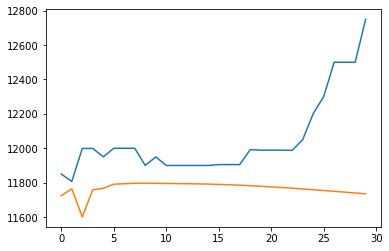

In [206]:
# plot the test data and predicitons
plt.plot(y_actual)
plt.plot(y_pred)
plt.show()

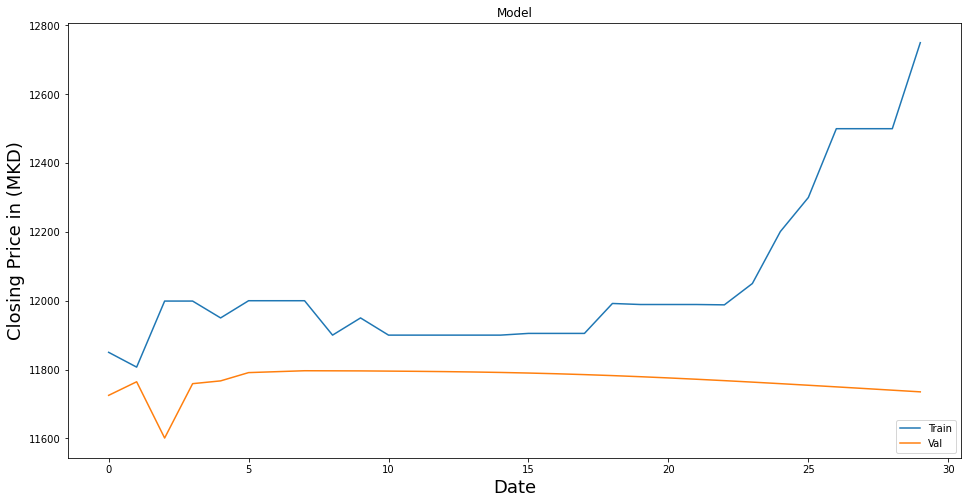

In [227]:
#plot the data
train_actual = scaler.inverse_transform(y_train.reshape(y_train.shape[0]*y_train.shape[1],1))
valid_actual = scaler.inverse_transform(y_valid.reshape(y_valid.shape[0]*y_valid.shape[1],1))
test_actual = scaler.inverse_transform(y_test.reshape(y_test.shape[0]*y_test.shape[1],1))
#valid['Predictions'] = predictions
#Visualize the Plot
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Closing Price in (MKD)', fontsize=18)
#plt.plot(train)
#plt.plot(train_actual)
#plt.plot(y_train_pred)
plt.plot(test_actual)
plt.plot(y_pred)
plt.legend(['Train','Val'], loc= 'lower right')
plt.show()